# Road Segmentation
DataSet https://www.kaggle.com/insaff/massachusetts-roads-dataset

In [3]:
import os
import sys
import shutil
import glob,math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import functools
import tensorflow as tf
import random
print(tf.__version__)
#import tensorflow.contrib as tfcontrib
import tensorflow_addons as tfa
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
height = 512
width = 512

2.2.0


<h1>Data Preprocessing</h2>
    <h4><li>crop data into smaller tiles 512*512 px</li>
    <li>clean data where no road mask present </li> </h4>

In [17]:

def dir_create(path):
    if (os.path.exists(path)) and (os.listdir(path) != []):
        shutil.rmtree(path)
        os.makedirs(path)
    if not os.path.exists(path):
        os.makedirs(path)
        
def crop(input_file, height, width):
    img = Image.open(input_file)
    img_width, img_height = img.size
    width_right=width
    height_bottom=height
    for i in range(math.ceil(img_height/height)):
        for j in range(math.ceil(img_width/width)):
            
            if (j+1)*width > img_width:
                width_right = img_width
            if (i+1)*height > img_height:
                height_bottom = img_height
            if (j+1)*width <= img_width and (i+1)*height <= img_height:
                height_bottom = (i+1)*height
                width_right = (j+1)*width
                
            box = (j*width, i*height, width_right, height_bottom)  
            #print(box,i,j,math.ceil(img_width//width),img_width, img_height)
            yield img.crop(box)
            

def split(inp_img_dir, inp_msk_dir, out_dir, height, width, 
          start_num):
    image_dir = os.path.join(out_dir, 'images')
    mask_dir = os.path.join(out_dir, 'masks')
    dir_create(out_dir)
    dir_create(image_dir)
    dir_create(mask_dir)
    img_list = [f for f in
                os.listdir(inp_img_dir)
                if os.path.isfile(os.path.join(inp_img_dir, f))]
    file_num = 0
    for infile in img_list:
        infile_path = os.path.join(inp_img_dir, infile)
        mask_path = os.path.join(inp_msk_dir,
                                   infile.split('.')[0] + '.png')
        
        if not os.path.exists(infile_path) or not os.path.exists(mask_path):
            print('file not exists:',infile.split('.')[0] + '.png')
            continue
        
        for k, piece in enumerate(crop(infile_path,
                                       height, width), start_num):
            img = Image.new('RGB', (height, width), 0)
            img.paste(piece)
            img_path = os.path.join(image_dir, 
                                    infile.split('.')[0]+ '_'
                                    + str(k).zfill(5) + '.png')
            img.save(img_path)
        infile_path = os.path.join(inp_msk_dir,
                                   infile.split('.')[0] + '.png')
        for k, piece in enumerate(crop(infile_path,
                                       height, width), start_num):
            msk = Image.new('RGB', (height, width), 0)
            msk.paste(piece)
            msk_path = os.path.join(mask_dir,
                                    infile.split('.')[0] + '_'
                                    + str(k).zfill(5) + '.png')
            msk.save(msk_path)
        file_num += 1
        sys.stdout.write("\rFile %s was processed." % file_num)
        sys.stdout.flush()

In [33]:

inp_img_dir = '/home/workspace/sat/data/road_segmentation_ideal/testing/input'
inp_msk_dir = '/home/workspace/sat/data/road_segmentation_ideal/testing/output'
out_dir = './test'
height = 512
width = 512
start_num = 1

split(inp_img_dir, inp_msk_dir, out_dir, height, width, 
          start_num)

File 13 was processed.

In [ ]:

inp_img_dir = '/home/workspace/sat/data/road_segmentation_ideal/training/input'
inp_msk_dir = '/home/workspace/sat/data/road_segmentation_ideal/training/output'
out_dir = './train'
height = 512
width = 512
start_num = 1

split(inp_img_dir, inp_msk_dir, out_dir, height, width, 
          start_num)

 <h4><li>clean images where no road mask present</li> </h4>

In [56]:
blank=[]
for f in glob.glob('/home/workspace/sat/train/masks/*.png'):
    img = cv2.imread(f,0)
    blank_pixel = np.sum(img)
    if(blank_pixel <1):
        blank.append(f)
        
len(blank)

534

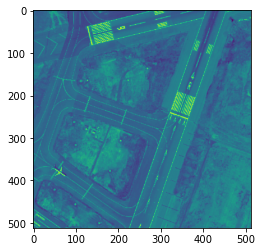

In [72]:
imgplot = plt.imshow(cv2.imread(blank[305].replace('masks','images'),0))
plt.show()

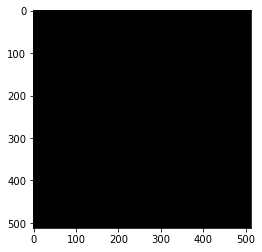

(None,)

In [75]:
imgplot = plt.imshow(cv2.imread(blank[305],3))
plt.show(),

In [ ]:
for b in blank:
    blank_files= os.path.basename(b)
    os.remove('/home/workspace/sat/train/masks/'+blank_files)
    os.remove('/home/workspace/sat/train/images/'+blank_files)
    
    


In [82]:
blank_post=[]
for f in glob.glob('/home/workspace/sat/train/masks/*.png'):
    img = cv2.imread(f,0)
    blank_pixel = np.sum(img)
    if(blank_pixel <1):
        blank_post.append(f)
        
len(blank_post)

0

# Data Visualization & Files

In [3]:
base='/home/workspace/sat/train/'
train_raw_images=[]
train_label_files=[]
for file in glob.glob("/home/workspace/sat/train/images/*.png"):
    blank_files= os.path.basename(file)
    train_raw_images.append(file)
    train_label_files.append(file.replace("images","masks"))
len(train_raw_images),len(train_label_files)     

(6702, 6702)

In [3]:
base='/home/workspace/sat/test/'
test_raw_images=[]
test_label_files=[]
for file in glob.glob("/home/workspace/sat/test/images/*.png"):
    blank_files= os.path.basename(file)
    test_raw_images.append(file)
    test_label_files.append(file.replace("images","masks"))
len(test_raw_images),len(test_label_files)    

(117, 117)

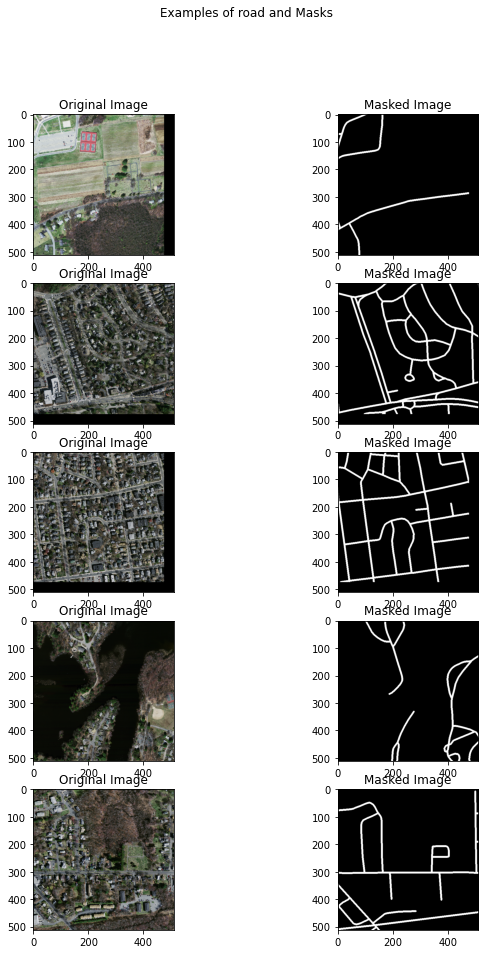

In [5]:
display_num = 5
def plotimages(imgs,masks):
    r_choices = np.random.choice(len(imgs), display_num)

    plt.figure(figsize=(10, 15))
    for i in range(0, display_num * 2, 2):
      img_num = r_choices[i // 2]
      x_pathname = imgs[img_num]
      y_pathname = masks[img_num]

      plt.subplot(display_num, 2, i + 1)
      plt.imshow(mpimg.imread(x_pathname))
      plt.title("Original Image")

      example_labels = Image.open(y_pathname)
      label_vals = np.unique(example_labels)

      plt.subplot(display_num, 2, i + 2)
      plt.imshow(example_labels)
      plt.title("Masked Image")  

    plt.suptitle("Examples of road and Masks")
    plt.show()
plotimages(train_raw_images,train_label_files)

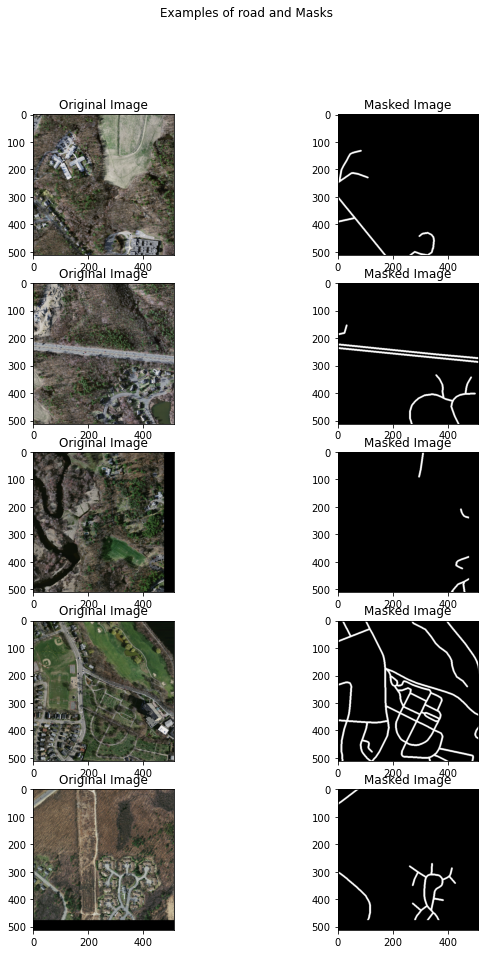

In [6]:
plotimages(test_raw_images,test_label_files)

# Custom Data generator & Test Train Split

In [7]:
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = train_test_split(train_raw_images,train_label_files, test_size=0.08, random_state=17,shuffle=True)
len(x_val_filenames),len(x_train_filenames)

(537, 6165)

In [71]:
img_shape = (512, 512, 3)
batch_size = 2
epochs = 5

def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_png(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    # These are gif images so they return as (num_frames, h, w, c)
    label_img = tf.image.decode_png(label_img_str)
    # The label image should only have values of 1 or 0, indicating pixel wise
    # object (car) or not (background). We take the first channel only.
    label_img = label_img[:, :, 0]
    label_img = tf.expand_dims(label_img, axis=-1)
    return img, label_img


# In[11]:


def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
            width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
            height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        # Translate both
        output_img = tfa.image.translate(output_img,
                                               [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                              [width_shift_range, height_shift_range])
    return output_img, label_img


# In[12]:


def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                    lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                    lambda: (tr_img, label_img))
    return tr_img, label_img


# In[13]:


def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.2,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=False,  # Random left right flip,
             width_shift_range=0,  # Randomly translate the image horizontally
             height_shift_range=0,
             brightness_delta=0,
             lower_contrast=0,
             upper_contrast=0):  # Randomly translate the image vertically
    if resize is not None:
        pass
        # Resize both images
        #label_img = tf.image.resize_image_with_crop_or_pad(label_img, resize[0],resize[1])
        #img = tf.image.resize_image_with_crop_or_pad(img, resize[0],resize[1])

    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)

    if lower_contrast and upper_contrast:
        img = tf.image.random_contrast(img, lower_contrast, upper_contrast)

    if brightness_delta:
        img = tf.image.random_brightness(img, brightness_delta)

    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, tf.float32) * scale
    img = tf.cast(img,tf.float32) * scale
    return img, label_img


def _tb_augment(img, label_img):
    #label_img = tf.image.resize_image_with_crop_or_pad(label_img, [img_shape[0], img_shape[1]])
    #img = tf.image.resize_image_with_crop_or_pad(img, [img_shape[0], img_shape[1]])

    label_img = tf.cast(label_img,tf.float32) * (1 / 255.)
    img = tf.cast(img,tf.float32) * (1 / 255.)

    return img, label_img


# In[14]:


def get_tb_dataset(fnames,
                   lnames,
                   preproc_fn=functools.partial(_tb_augment),
                   threads=6,
                   batch_set_size=1,
                   shuffle=False):
    filenames, labels = zip(*random.sample(list(zip(fnames, lnames)), 300))

    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((list(filenames), list(labels)))

    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
    # print(dataset)
    if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        assert batch_set_size == 1, "Batching images must be of the same size"

    dataset = dataset.map(preproc_fn, num_parallel_calls=threads)

    if shuffle:
        dataset = dataset.shuffle(num_x)

    # It's necessary to repeat our data for all epochs
    #dataset = dataset.batch(batch_set_size)
    #dataset = dataset.repeat()
    #dataset = dataset.prefetch(2)#tf.data.experimental.AUTOTUNE

    dataset = dataset.repeat().batch(batch_size)

    return dataset


def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=6,
                         batch_set_size=batch_size,
                         shuffle=False):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
    # print(dataset)
    if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        assert batch_set_size == 1, "Batching images must be of the same size"

    dataset = dataset.map(preproc_fn, num_parallel_calls=threads)

    if shuffle:
        dataset = dataset.shuffle(num_x)

    # It's necessary to repeat our data for all epochs
    #dataset = dataset.batch(batch_set_size)
    #dataset = dataset.repeat()
    #dataset = dataset.prefetch(2) #tf.data.experimental.AUTOTUNE
    dataset = dataset.repeat().batch(batch_size)
    return dataset


# In[15]:



In [6]:
tr_cfg = {
    'resize': None,
    'scale': 1 / 255.,
    'hue_delta': 0.2,
    'horizontal_flip': True,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1,
    'brightness_delta': 0.125,
    'lower_contrast': 0.5,
    'upper_contrast': 1.5

}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

# In[16]:


val_cfg = {
    'resize': None,
    'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

# In[17]:


In [19]:

train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_set_size=batch_size,
                               shuffle=False)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames,
                              preproc_fn=val_preprocessing_fn,
                              batch_set_size=batch_size,shuffle=False)
test_ds = get_baseline_dataset(test_raw_images,test_label_files, 
                               preproc_fn=val_preprocessing_fn,batch_set_size=batch_size,
                               shuffle=False)


In [68]:
'''
import tensorflow_datasets as tfds
for batch_of_imgs, label in tfds.as_numpy(dataset):
    #print(type(image), type(label), label)
    plt.figure(figsize=(10, 10))
    img = batch_of_imgs[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    print(label.shape,img.shape)

    plt.subplot(1, 2, 2)
    plt.imshow(label[0, :, :, 0])
    plt.show()
'''

'\nimport tensorflow_datasets as tfds\nfor batch_of_imgs, label in tfds.as_numpy(dataset):\n    #print(type(image), type(label), label)\n    plt.figure(figsize=(10, 10))\n    img = batch_of_imgs[0]\n\n    plt.subplot(1, 2, 1)\n    plt.imshow(img)\n    print(label.shape,img.shape)\n\n    plt.subplot(1, 2, 2)\n    plt.imshow(label[0, :, :, 0])\n    plt.show()\n'

# Model Training

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import segmentation_models as sm
from segmentation_models import Unet
from tensorflow.keras.optimizers import Adam
from segmentation_models.losses import bce_jaccard_loss, bce_dice_loss,binary_focal_loss
from segmentation_models.metrics import iou_score
# reduces learning rate on plateau
lr_reducer = ReduceLROnPlateau(factor=0.1,
                               cooldown= 10,
                               patience=10,verbose =1,
                               min_lr=0.1e-5)
mode_autosave = ModelCheckpoint("model.{epoch:02d}.h5",monitor='val_iou_score', 
                                   mode = 'max', save_best_only=True)

# stop learining as metric on validatopn stop increasing
early_stopping = EarlyStopping(patience=5, verbose=1, mode = 'auto') 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

callbacks = [mode_autosave, lr_reducer, early_stopping]

n_classes =1
activation = 'sigmoid' if n_classes == 1 else 'softmax'
tf.keras.backend.clear_session()
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
model = Unet(backbone_name = 'efficientnetb0', encoder_weights='imagenet',classes=n_classes,activation=activation)
model.compile(optimizer = Adam(),
                    loss=binary_focal_loss, metrics=[metrics])

In [26]:

history = model.fit_generator(train_ds, shuffle =True,
                  epochs=20, workers=2, use_multiprocessing=False,
                 steps_per_epoch = len(x_train_filenames) // batch_size,
                  validation_data = val_ds,
                              validation_steps = len(x_val_filenames) // batch_size,
                  verbose = 1, callbacks=callbacks) 

Epoch 1/20
3082/3082 [==============================] - 1197s 388ms/step - loss: 0.0096 - iou_score: 0.3194 - f1-score: 0.4656 - val_loss: 0.0087 - val_iou_score: 0.2995 - val_f1-score: 0.4493 - lr: 0.0010
Epoch 2/20
3082/3082 [==============================] - 1197s 388ms/step - loss: 0.0077 - iou_score: 0.4129 - f1-score: 0.5710 - val_loss: 0.0084 - val_iou_score: 0.3175 - val_f1-score: 0.4657 - lr: 0.0010
Epoch 3/20
3082/3082 [==============================] - 1191s 386ms/step - loss: 0.0074 - iou_score: 0.4376 - f1-score: 0.5947 - val_loss: 0.0075 - val_iou_score: 0.4528 - val_f1-score: 0.6113 - lr: 0.0010
Epoch 4/20
3082/3082 [==============================] - 1189s 386ms/step - loss: 0.0072 - iou_score: 0.4518 - f1-score: 0.6088 - val_loss: 0.0075 - val_iou_score: 0.4166 - val_f1-score: 0.5722 - lr: 0.0010
Epoch 5/20
3082/3082 [==============================] - 1190s 386ms/step - loss: 0.0071 - iou_score: 0.4588 - f1-score: 0.6148 - val_loss: 0.0072 - val_iou_score: 0.4911 - val_

In [11]:
model.load_weights('model.16.h5')

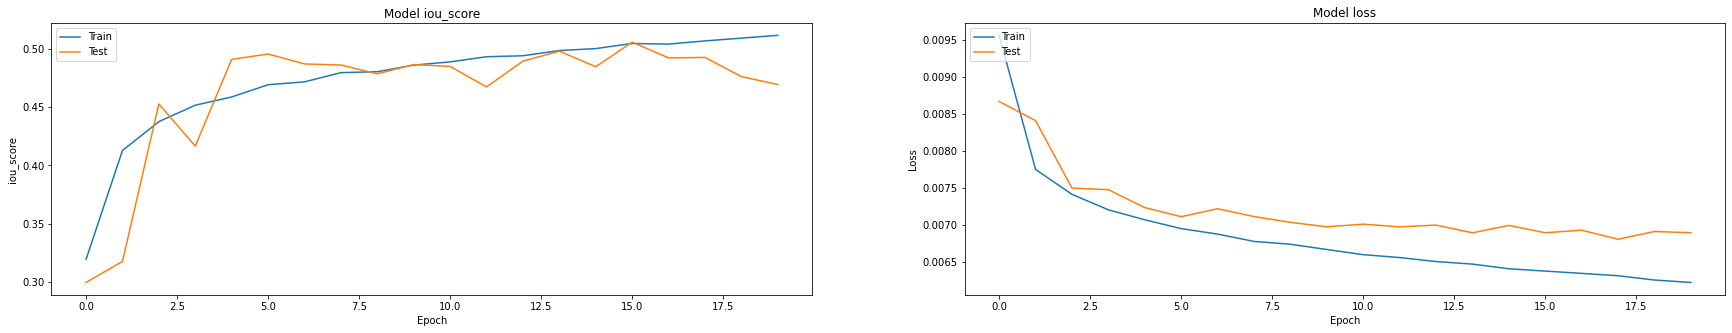

In [59]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Performance Metrics

In [ ]:
scores = model.evaluate_generator(test_ds,len(test_raw_images)//batch_size)

In [43]:
predictions=[]
gt=[]
for f in test_raw_images:
    predictions.append(np.array(predict(f,threshold=0.35)))
    
    label_img_str = tf.io.read_file(f.replace('images','masks'))
    # These are gif images so they return as (num_frames, h, w, c)
    label_img = tf.image.decode_png(label_img_str)
    # The label image should only have values of 1 or 0, indicating pixel wise
    # object (car) or not (background). We take the first channel only.
    label_img = label_img[:, :, 0]
    label_img = tf.expand_dims(label_img, axis=-1)
    gt.append(np.array(label_img))
    
from statistics import mean
def getPR(predictions,gt):
    precisions = []
    recalls = []
    for i in range(len(predictions)):
        pred_flat = predictions[i].flatten()
        gt_flat = gt[i].flatten()
        tp = np.sum(np.logical_and(gt_flat == 255, pred_flat == 255))
        tn = np.sum(np.logical_and(gt_flat == 0, pred_flat == 0))
        fp = np.sum(np.logical_and(gt_flat == 0, pred_flat == 255))
        fn = np.sum(np.logical_and(gt_flat == 255, pred_flat == 0))
        precision = tp /  (tp + fp)
        recall = tp /  (tp + fn)
        recalls.append(recall)
        precisions.append(precision)
    return mean([x for x in precisions if ~np.isnan(x)]),mean([x for x in recalls if ~np.isnan(x)])

       

In [42]:
p,r=getPR(predictions,gt)
print("Precision:{}".format(p))
print("Recall: {}".format(r))
print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Precision:0.7467161044527089
Recall: 0.7463540785659881
Loss: 0.0085487
mean iou_score: 0.48416
mean f1-score: 0.64435


<ipython-input-40-ad9c67a762d6>:13: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp /  (tp + fn)
<ipython-input-40-ad9c67a762d6>:12: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp /  (tp + fp)


# Display sample Prediction

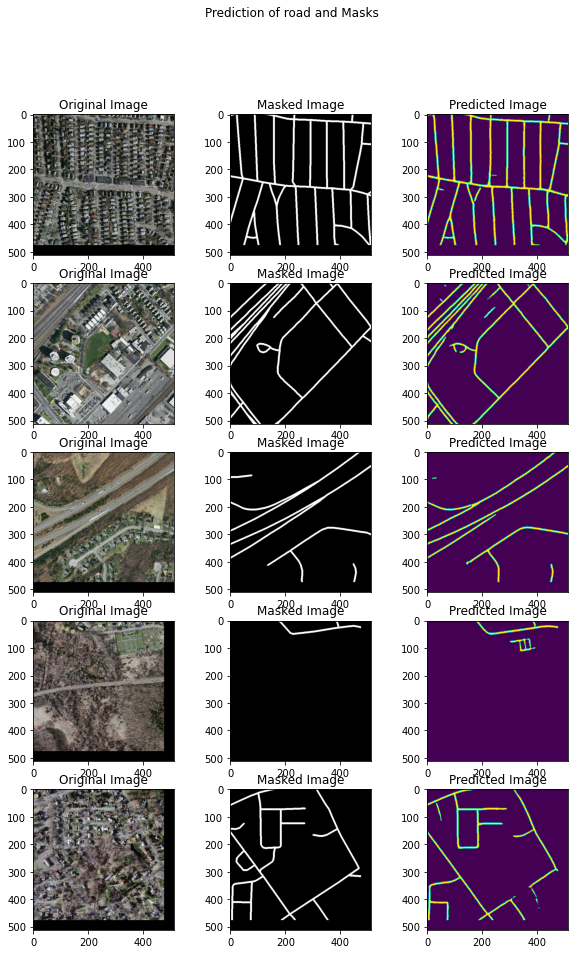

In [27]:
display_num = 5
def predict(fname,threshold=0.1):
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_png(img_str, channels=3)
    img = np.multiply(img, 1 / 255.)
    new_img = np.expand_dims(img, axis=0)
    predicted_label = model.predict(new_img)
    #predicted_label = np.reshape(predicted_label, (512, 512))
    final_img = np.zeros((512, 512,1), np.uint8)
    gs_img = np.multiply(predicted_label, 255)
    thresh_indices = predicted_label[:, :] > threshold
    final_img[thresh_indices[0]] = 255
    return Image.fromarray(np.squeeze(final_img, axis=2))

def predictimg(img,threshold=0.1):
    #img_str = tf.io.read_file(fname)
    #img = tf.image.decode_png(img_str, channels=3)
    img = np.multiply(img, 1 / 255.)
    new_img = np.expand_dims(img, axis=0)
    predicted_label = model.predict(new_img)
    #predicted_label = np.reshape(predicted_label, (512, 512))
    final_img = np.zeros((512, 512,1), np.uint8)
    gs_img = np.multiply(predicted_label, 255)
    thresh_indices = predicted_label[:, :] > threshold
    final_img[thresh_indices[0]] = 255
    return Image.fromarray(np.squeeze(final_img, axis=2))

def plotPredictimages(imgs,masks,threshold=0.1):
    r_choices = np.random.choice(len(imgs), display_num)

    plt.figure(figsize=(10, 15))
    for i in range(0, display_num * 3, 3):
      img_num = r_choices[i // 3]
      x_pathname = imgs[img_num]
      y_pathname = masks[img_num]

      plt.subplot(display_num, 3, i + 1)
      plt.imshow(mpimg.imread(x_pathname))
      plt.title("Original Image")

      example_labels = Image.open(y_pathname)
      label_vals = np.unique(example_labels)

      plt.subplot(display_num, 3, i + 2)
      plt.imshow(example_labels)
      plt.title("Masked Image")
      
      predict_labels = predict(x_pathname,threshold)
      pred_vals = np.unique(predict_labels)

      plt.subplot(display_num, 3, i + 3)
      plt.imshow(predict_labels)
      plt.title("Predicted Image")
    #plt.savefig('pred.png')
    plt.suptitle("Prediction of road and Masks")
    plt.show()
plotPredictimages(test_raw_images,test_label_files,0.4)

# Split and Merge Inference 1500*1500 raw image

In [66]:
def merge_images(files,w=1500,h=1500):
    image1 = files[0]
    image2 = files[1]
    image3 = files[2]
    
    image4 = files[3]
    image5 = files[4]
    image6 = files[5]
    
    image7 = files[6]
    image8 = files[7]
    image9 = files[8]
    
    result = Image.new('RGB', (width*3, height*3))
    result.paste(im=image1, box=(0, 0))
    result.paste(im=image2, box=(width*1, 0))
    result.paste(im=image3, box=(width*2, 0))
    
    result.paste(im=image4, box=(0, height*1))
    result.paste(im=image5, box=(width*1, height*1))
    result.paste(im=image6, box=(width*2, height*1))
    
    
    result.paste(im=image7, box=(0, height*2))
    result.paste(im=image8, box=(width*1, height*2))
    result.paste(im=image9, box=(width*2, height*2))
     
    return result.crop((0, 0, w, h))



def split_pred(infile_path,height=512,width=512):
    result=[]
    for k, piece in enumerate(crop(infile_path,
                                       height, width), 1):
        img = Image.new('RGB', (height, width), 0)
        img.paste(piece)
        
        result.append(predictimg(img,0.37))
    return result
 
def plotInferenceMerged(raw,org_mask,merged):
    fig, axs = plt.subplots(1,3, figsize=(30,20))
    axs[0].imshow(raw)
    axs[0].set_title("Input Image")
    axs[1].imshow(org_mask)
    axs[1].set_title("GT Image")
    axs[2].imshow(merged)
    axs[2].set_title("predicted Image")
    plt.savefig('pred2.png')
    plt.show()

In [64]:
tile_img=split_pred('/home/workspace/sat/data/road_segmentation_ideal/testing/input/img-8.png')
merged = merge_images(tile_img)
org_mask = Image.open('/home/workspace/sat/data/road_segmentation_ideal/testing/output/img-8.png')
raw = Image.open('/home/workspace/sat/data/road_segmentation_ideal/testing/input/img-8.png')

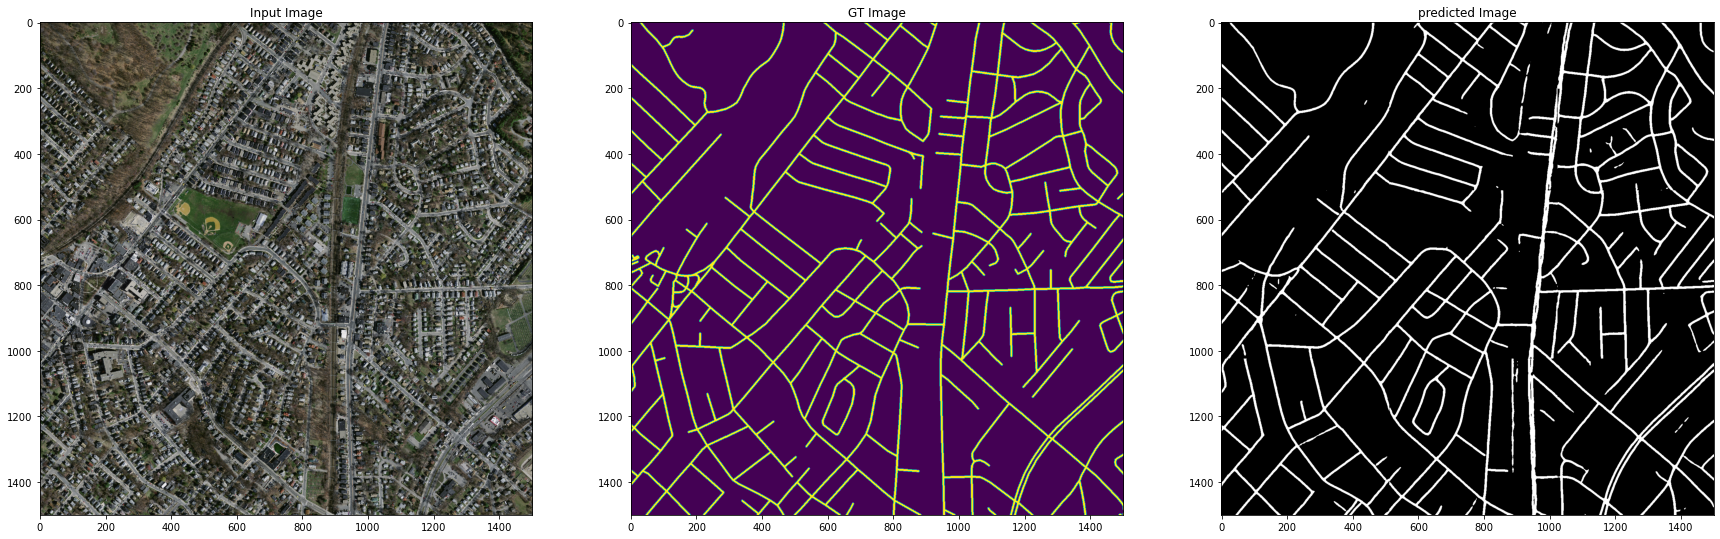

In [67]:
plotInferenceMerged(raw,org_mask,merged)